In [2]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\rahul\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\rahul\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
!nvidia-smi

NVIDIA-SMI has failed because you do not have suffient permissions. Please try running as an administrator.


In [5]:
import pandas as pd
import torch 
import matplotlib.pyplot as plt
from fredapi import Fred
import numpy as np

In [6]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.environ["API_KEY"]

In [7]:
fred = Fred(api_key=api_key)
data = fred.get_series("NROU")
data.tail()

2033-10-01    4.236570
2034-01-01    4.230920
2034-04-01    4.225190
2034-07-01    4.219381
2034-10-01    4.213503
dtype: float64

In [8]:
data = pd.DataFrame(data,columns=['Rate'])
data.reset_index(inplace=True)
data.head()

index      Rate
0 1949-01-01  5.255053
1 1949-04-01  5.261516
2 1949-07-01  5.268013
3 1949-10-01  5.274564
4 1950-01-01  5.281182

In [9]:
data.rename(columns={"index": "Date"}, inplace=True)
data.head()

Date      Rate
0 1949-01-01  5.255053
1 1949-04-01  5.261516
2 1949-07-01  5.268013
3 1949-10-01  5.274564
4 1950-01-01  5.281182

In [10]:
data.loc[data['Date']=='1980-01-01']
data = data.iloc[124:]

In [11]:
data.head()
data.reset_index(drop=True)

Date      Rate
0   1980-01-01  6.217371
1   1980-04-01  6.210709
2   1980-07-01  6.203388
3   1980-10-01  6.195496
4   1981-01-01  6.187123
..         ...       ...
215 2033-10-01  4.236570
216 2034-01-01  4.230920
217 2034-04-01  4.225190
218 2034-07-01  4.219381
219 2034-10-01  4.213503

[220 rows x 2 columns]

In [12]:
rates = data["Rate"].to_numpy()
rates_tensor = torch.from_numpy(rates).unsqueeze(dim=1)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
cut_batch = int(len(rates_tensor) * .6)
end_batch = int(len(rates_tensor) * .1)

X_train = rates_tensor[:end_batch].type(torch.float32).to(device)
X_eval = rates_tensor[end_batch:int(end_batch*2)].type(torch.float32).to(device)
X_test = rates_tensor[int(end_batch*2):int(end_batch*3)].type(torch.float32).to(device)
x_test = rates_tensor[int(end_batch*3):int(end_batch*4)].type(torch.float32).to(device)

len(X_train), len(X_eval), len(X_test)

(22, 22, 22)

In [15]:
def plot_predictions(train_data = X_train, train_labels = X_eval,
                     test_data = X_test, test_labels = X_eval, predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    plt.scatter(test_data, test_labels, c='r', s=4, label="Testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c='g', s=4, label="Predictions")
        
    plt.legend(prop={"size":12})

    plt.plot()


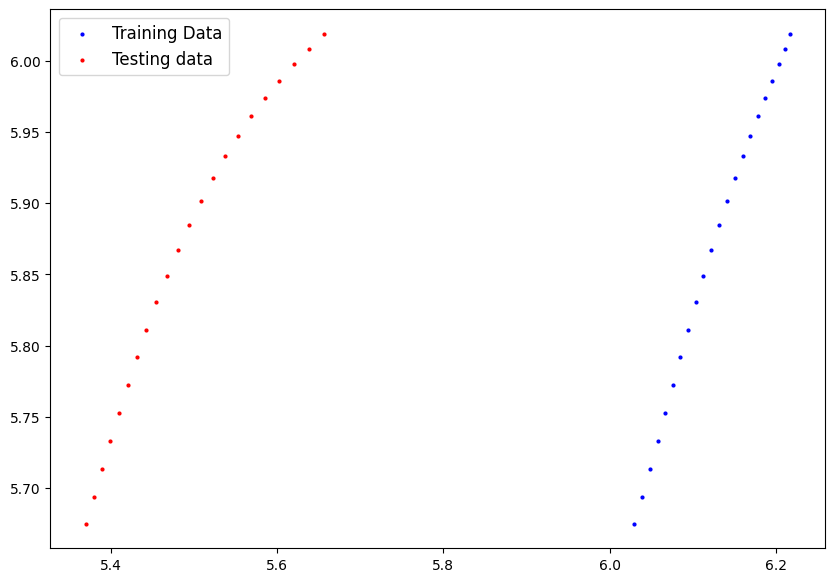

In [16]:
plot_predictions()

In [17]:
import torch.nn as nn
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [18]:
torch.manual_seed(42)
model0 = LinearRegressionModel()
list(model0.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

In [19]:
model0.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [20]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.Adam(model0.parameters(), lr=.001)

In [21]:
def noLossFr(epochs):
    for epoch in range(epochs):

        model0.train()
        
        x_pred = model0(X_train)
        
        loss = loss_fn(x_pred, X_eval)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        print(loss)

noLossFr(100000)



tensor(0.3507, grad_fn=<MeanBackward0>)
tensor(0.3436, grad_fn=<MeanBackward0>)
tensor(0.3365, grad_fn=<MeanBackward0>)
tensor(0.3293, grad_fn=<MeanBackward0>)
tensor(0.3222, grad_fn=<MeanBackward0>)
tensor(0.3151, grad_fn=<MeanBackward0>)
tensor(0.3080, grad_fn=<MeanBackward0>)
tensor(0.3008, grad_fn=<MeanBackward0>)
tensor(0.2937, grad_fn=<MeanBackward0>)
tensor(0.2866, grad_fn=<MeanBackward0>)
tensor(0.2795, grad_fn=<MeanBackward0>)
tensor(0.2723, grad_fn=<MeanBackward0>)
tensor(0.2652, grad_fn=<MeanBackward0>)
tensor(0.2581, grad_fn=<MeanBackward0>)
tensor(0.2510, grad_fn=<MeanBackward0>)
tensor(0.2438, grad_fn=<MeanBackward0>)
tensor(0.2367, grad_fn=<MeanBackward0>)
tensor(0.2296, grad_fn=<MeanBackward0>)
tensor(0.2224, grad_fn=<MeanBackward0>)
tensor(0.2153, grad_fn=<MeanBackward0>)
tensor(0.2082, grad_fn=<MeanBackward0>)
tensor(0.2011, grad_fn=<MeanBackward0>)
tensor(0.1939, grad_fn=<MeanBackward0>)
tensor(0.1868, grad_fn=<MeanBackward0>)
tensor(0.1797, grad_fn=<MeanBackward0>)


tensor(0.5572)


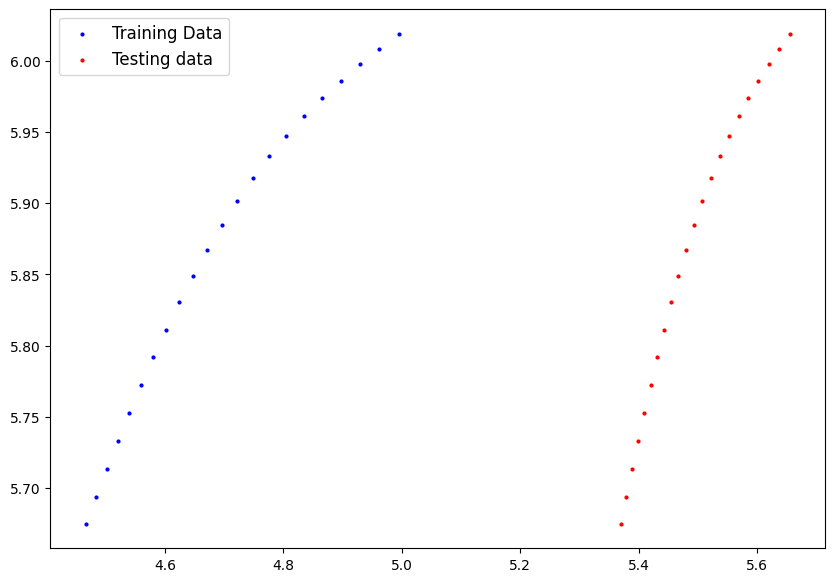

In [22]:
model0.eval()
with torch.inference_mode():
    test_preds = model0(X_test)
    loss = loss_fn(test_preds, x_test)
    plot_predictions(test_preds)
    print(loss)
